In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import tv_model
from cosmosis.learning import Learn, Selector
from cosmosis.dataset import LoadImage, AsTensor, Transpose
import cosmosis.dataset as dataset

from dataset import Ranzcr
from learning import RSelector

from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

from IPython.display import display


In [ ]:
ds_params={'embed': [],
            'image_dir': './data/ranzcr/train',
            'target_csv': './data/ranzcr/train.csv',
            'target_type': 'ETT',
            'transform': transforms.Compose([LoadImage(),
                                             transforms.Resize(224),
                                             ]),
            'target_transform': None}

ds = Ranzcr(**ds_params)
ids = dataset.ImageDatasetStats()

for i in ds.ds_idx:
    ids(ds[i][0])
    
print(ids.stats.mean) #123.2/255=.483
print(ids.stats.stddev) #59.4/255=.233

CDataset created...
CDataset created...
CDataset created...
TorchVision model wide_resnet50_2 loaded...
learning time: 0:01:09.608121
epoch: 0, lr: 0.01
train loss: 3.696576861436974, val loss: 3.176920211138716
sk_train_log: 0.8239674391922773, sk_val_log: 0.36239768234209496
learning time: 0:02:16.555932
epoch: 1, lr: 0.01
train loss: 1.4415988398522026, val loss: 3.1848599791034453
sk_train_log: 0.8800799325034097, sk_val_log: 0.4737262105376605
learning time: 0:03:23.459573
epoch: 2, lr: 0.01
train loss: 1.6492737607042727, val loss: 4.093079949362205
sk_train_log: 0.6515193142733731, sk_val_log: 0.5460018747513418
learning time: 0:04:30.850724
epoch: 3, lr: 0.01
train loss: 0.9296215488174835, val loss: 5.24937079001403
sk_train_log: 0.8920904515863775, sk_val_log: 0.5376319550701893
learning time: 0:05:37.437342
epoch: 4, lr: 0.01
train loss: 1.422760213186848, val loss: 2.639705796425721
sk_train_log: 0.7073060758821257, sk_val_log: 0.38401696521496875
learning time: 0:06:43.696

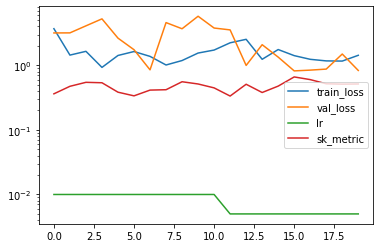

In [2]:
ds_params={'train_params': {'embed': [],
                            'image_dir': './data/ranzcr/train',
                            'target_csv': './data/ranzcr/train.csv',
                            'target_type': 'ETT',
                            'transform': transforms.Compose([LoadImage(),
                                                             transforms.RandomRotation(10),
                                                             transforms.Resize(1500),
                                                             transforms.CenterCrop(1200),
                                                             transforms.Resize(300),
                                                             transforms.RandomCrop(244),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize(.483,.233),
                                                             ]),
                            'target_transform': transforms.Compose([
                                                       dataset.AsTensor(),
                                                       dataset.Squeeze()])},
           'val_params': {'embed': [],
                          'image_dir': './data/ranzcr/train',
                          'target_csv': './data/ranzcr/train.csv',
                          'target_type': 'ETT',
                          'transform': transforms.Compose([LoadImage(),
                                                           transforms.Resize(1500),
                                                           transforms.CenterCrop(1200),
                                                           transforms.Resize(300),
                                                           transforms.CenterCrop(244),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize(.483,.233),
                                                           ]),
                          'target_transform': transforms.Compose([
                                                       dataset.AsTensor(),
                                                       dataset.Squeeze()])},
           'test_params': {'embed': [],
                           'image_dir': './data/ranzcr/train',
                           'target_csv': './data/ranzcr/train.csv',
                           'target_type': 'ETT',
                           'transform': transforms.Compose([LoadImage(),
                                                            transforms.Resize(1500),
                                                            transforms.CenterCrop(1200),
                                                            transforms.Resize(300),
                                                            transforms.CenterCrop(244),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(.483,.233),
                                                            ]),
                          'target_transform': transforms.Compose([
                                                       dataset.AsTensor(),
                                                       dataset.Squeeze()])}}

model_params = {'model_name': 'wide_resnet50_2',
                'in_channels': 1,
                'tv_params': {'num_classes': 4}} 

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}
    
opt_params = {'lr': 0.01}
crit_params = {'reduction': 'sum'}

#RSelector balances classes (target_type) of the Ranzcr ds
sample_params = {'set_seed': False,
                 'splits': (.7,.15),
                 'target_type': 'ETT'}

sched_params = {'factor': .5,
                'patience': 4,
                'cooldown': 4}

learn = Learn([Ranzcr,Ranzcr,Ranzcr], 
              tv_model, 
              RSelector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss, 
              model_params=model_params, ds_params=ds_params, sample_params=sample_params,
              opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
              metrics_params=metrics_params,
              adapt=False, load_model=False, load_embed=False, save_model=True,
              batch_size=16, epochs=20)